In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# فصل ۴ — مبانی یادگیری نظارت‌شده
## درس ۱۲: رگرسیون صدکی و بازه‌های پیش‌بینی (مقدمه)

**نام دوره:** دوره مقدماتی یادگیری ماشین  
**تعداد کل فصل‌های این مخزن:** ۳۷ فصل  
**تعداد درس‌های فصل ۴:** ۱۳ درس  
**این نوت‌بوک:** درس ۱۲ (رگرسیون صدکی و بازه‌های پیش‌بینی — مقدمه)

---

### هدف این درس چیست؟
در بسیاری از پروژه‌های یادگیری نظارت‌شده، خروجی مدل فقط یک **پیش‌بینی نقطه‌ای** است (مثلاً «قیمت مورد انتظار این خانه ۲۵۰ هزار دلار است»). اما در عمل، ذی‌نفعان معمولاً خروجی‌های **همراه با عدم‌قطعیت** می‌خواهند:

- **ریسک:** «بدترین سناریو چقدر می‌تواند باشد؟»  
- **برنامه‌ریزی:** «دامنه نتایج محتمل چیست؟»  
- **آستانه‌های تصمیم:** «احتمال عبور از یک حد چقدر است؟»  
- **ناهمگنی خطا:** «آیا خطا برای برخی گروه‌ها بزرگ‌تر می‌شود؟»

در این درس با **رگرسیون صدکی (Quantile Regression)** آشنا می‌شوید؛ ابزاری کلاسیک برای مدل‌سازی **صدک‌های شرطی** (مثلاً صدک دهم یا نودمِ خروجی با شرط ویژگی‌ها). این مدل‌ها مسیر مستقیمی برای ساخت **بازه‌های پیش‌بینی (Prediction Intervals)** فراهم می‌کنند؛ به‌ویژه وقتی نویز ناهمسان‌واریانس (heteroscedastic) یا توزیع خطا نامتقارن باشد.

---

### اهداف یادگیری
در پایان این درس انتظار می‌رود بتوانید:

1. **صدک‌ها** و تفسیر **صدک‌های شرطی** $Q_\tau(Y\mid X=x)$ را توضیح دهید.
2. نشان دهید رگرسیون صدکی معادل کمینه‌سازی **تابع زیان پین‌بال (Pinball/Check Loss)** است.
3. مدل‌های صدکی پایه را در پایتون برازش کنید (رگرسیون خطیِ صدکی).
4. با استفاده از جفتِ صدک‌ها، **بازه پیش‌بینی** بسازید.
5. بازه‌ها را با معیارهای **پوشش (coverage)** و **پهنای بازه (width)** ارزیابی کنید و مشکلات رایج (مانند crossing) را تشخیص دهید.
6. در سطح مقدماتی بفهمید چگونه **کالیبراسیون کانفورمال** می‌تواند پوشش بازه را بهبود دهد.

---

### پیش‌نیازها
- آشنایی با train/test split و معیارهای رگرسیون (MAE، MSE، RMSE).
- درک پایه از رگرسیون خطی.
- تسلط عملی روی pandas / numpy / matplotlib.

---

### نکته درباره نمادگذاری
در ادامه:
- $Y$ هدف (مثلاً price) است.
- $X$ بردار ویژگی‌ها است.
- $\tau \in (0,1)$ سطح صدک است (مثلاً $\tau=0.1$ یعنی صدک ۱۰٪).
- $Q_\tau(Y\mid X=x)$ صدک شرطیِ $\tau$ از $Y$ با شرط $X=x$ است.


## ۱. صدک‌ها: از «مقدار معمول» تا «دم توزیع»

**صدک** تعمیمی از مفهوم میانه است. به‌صورت شهودی:
- **میانه** همان صدک ۵۰٪ است؛ نیمی از داده‌ها پایین‌تر و نیمی بالاتر.
- **صدک ۹۰٪** سطحی است که ۹۰٪ مقادیر زیر آن قرار می‌گیرند.

به‌صورت رسمی، اگر $Y$ متغیر تصادفی حقیقی با تابع توزیع تجمعی $F_Y(y)=P(Y\le y)$ باشد، صدک $\tau$ را می‌توان این‌گونه تعریف کرد:
$$
Q_\tau(Y) = \inf\{y \in \mathbb{R}: F_Y(y) \ge \tau\}.
$$

### صدک‌های شرطی
در یادگیری نظارت‌شده، ما به توزیع شرطی علاقه داریم:
$$
Q_\tau(Y\mid X=x).
$$

این مقدار پاسخ می‌دهد: «در میان نمونه‌هایی که ویژگی‌های مشابه $x$ دارند، صدک $\tau$ از خروجی چیست؟»

- $\tau=0.5$ خروجی «معمول» و مقاوم (میانه) را می‌دهد.
- صدک‌های پایین (مثل $\tau=0.05$) سناریوهای بدبینانه را نشان می‌دهند.
- صدک‌های بالا (مثل $\tau=0.95$) سناریوهای خوش‌بینانه را نشان می‌دهند.

### چرا صدک‌های شرطی مهم‌اند؟
در بسیاری از داده‌ها **ناهمسان‌واریانس** وجود دارد: پراکندگی $Y$ با تغییر $X$ تغییر می‌کند.
- مثال: خطای قیمت‌گذاری برای خانه‌های گران‌تر می‌تواند بزرگ‌تر باشد.
- مثال: عدم‌قطعیت قیمت الماس ممکن است با افزایش carat بیشتر شود.

رگرسیون میانگین (OLS) $\mathbb{E}[Y\mid X]$ را یاد می‌گیرد، اما مستقیماً شکل دم‌ها یا پراکندگی را توصیف نمی‌کند. رگرسیون صدکی مستقیماً به بخش‌های مختلف توزیع شرطی دسترسی می‌دهد.


## ۲. رگرسیون صدکی: تابع زیان پین‌بال (Check Loss)

رگرسیون صدکی $Q_\tau(Y\mid X)$ را با حل یک مسئله بهینه‌سازی برآورد می‌کند. اگر پیش‌بینی $\hat{y}$ و مقدار واقعی $y$ باشد، باقیمانده را $u=y-\hat{y}$ تعریف می‌کنیم. **زیان پین‌بال** در سطح صدک $\tau$ چنین است:

$$
\rho_\tau(u) = \begin{cases}
\tau u, & u \ge 0\\
(\tau - 1)u, & u < 0
\end{cases}
$$

یا به‌صورت فشرده‌تر:
$$
\rho_\tau(u) = u\,(\tau - \mathbb{1}[u<0]).
$$

### شهود
- اگر $u>0$ (کم‌پیش‌بینی کرده‌ایم)، جریمه متناسب با $\tau$ است.
- اگر $u<0$ (زیادپیش‌بینی کرده‌ایم)، جریمه متناسب با $1-\tau$ است.

پس برای صدک بالا (مثلاً $\tau=0.9$)، کم‌پیش‌بینی جریمه سنگین‌تری دارد؛ بنابراین منحنی برازش‌شده بالاتر می‌رود تا تقریباً ۹۰٪ نقاط زیر آن قرار بگیرند (در حالت ایده‌آل).

### مسئله برآورد
در مدل خطیِ صدکی:
$$
\hat{y} = \beta_0 + x^T\beta.
$$

پارامترها با کمینه‌سازی زیر به‌دست می‌آیند:
$$
\min_{\beta_0,\beta} \sum_{i=1}^n \rho_\tau\big(y_i - (\beta_0 + x_i^T\beta)\big).
$$

این مسئله **کوژ** است و در مدل‌های خطی می‌توان آن را به **برنامه‌ریزی خطی (LP)** تبدیل کرد.

### ارتباط با رگرسیون‌های دیگر
- OLS خطای مربعی را کمینه می‌کند و **میانگین شرطی** را می‌دهد.
- رگرسیون میانه ($\tau=0.5$) خطای قدرمطلق را کمینه می‌کند و **میانه شرطی** را می‌دهد.
- برای $\tau$ عمومی، **صدک شرطی** برآورد می‌شود.


## ۳. بازه پیش‌بینی در مقابل بازه اطمینان

این دو مفهوم اغلب با هم اشتباه گرفته می‌شوند:

### بازه اطمینان (CI)
CI عدم‌قطعیت یک **پارامتر** یا **برآورد میانگین** را بیان می‌کند.
مثال: CI ۹۵٪ برای میانگین قیمت خانه با شرط یک ویژگی مشخص.

### بازه پیش‌بینی (PI)
PI عدم‌قطعیت یک **مشاهده آینده** را بیان می‌کند.
مثال: PI ۹۰٪ برای قیمت یک خانه مشخص.

رگرسیون صدکی مستقیماً برای PI مناسب است:
اگر بتوانید $Q_{\alpha/2}(Y\mid X=x)$ و $Q_{1-\alpha/2}(Y\mid X=x)$ را تخمین بزنید، یک PI مرکزی با سطح $(1-\alpha)$ برابر است با:
$$
\big[Q_{\alpha/2}(Y\mid X=x),\; Q_{1-\alpha/2}(Y\mid X=x)\big].
$$

مثلاً برای $\alpha=0.10$ (PI ۹۰٪):
- کران پایین: صدک $\tau=0.05$
- کران بالا: صدک $\tau=0.95$

### ارزیابی بازه: پوشش و پهنا
اگر بازه‌های پیش‌بینی $[\ell_i, u_i]$ روی داده تست داشته باشیم:
- **پوشش تجربی**:
$$
\widehat{\text{cov}} = \frac{1}{n}\sum_{i=1}^n \mathbb{1}[\ell_i \le y_i \le u_i].
$$
- **میانگین پهنا**:
$$
\widehat{w} = \frac{1}{n}\sum_{i=1}^n (u_i-\ell_i).
$$

هدف معمولاً نزدیک بودن پوشش به مقدار اسمی و کوچک بودن پهنا (با حفظ پوشش) است.


## ۴. تمرین عملی: داده مصنوعی با ناهمسان‌واریانس

قبل از کار با داده‌های واقعی، دیدن رفتار رگرسیون صدکی در یک مثال کنترل‌شده مفید است؛ جایی که:
- میانگین واقعی نسبت به $x$ خطی است.
- واریانس نویز با $x$ افزایش می‌یابد.
- بنابراین انتظار داریم نوارهای صدکی با افزایش $x$ بازتر شوند.

در سلول‌های بعد:
1. داده مصنوعی با نویز افزایشی تولید می‌کنیم.
2. OLS (میانگین) و منحنی‌های صدکی را برازش می‌کنیم.
3. نشان می‌دهیم چگونه صدک‌های شرطی، رشد عدم‌قطعیت را مدل می‌کنند.

این دقیقاً همان چیزی است که در داده‌های قیمت، تقاضا، ریسک و غیره نیز رخ می‌دهد.


In [2]:
# Core scientific Python stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from dataclasses import dataclass

# Reproducibility
RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

# Optional: scikit-learn utilities (used when available)
try:
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.linear_model import QuantileRegressor
    SKLEARN_OK = True
except Exception as e:
    SKLEARN_OK = False
    print("scikit-learn is not available (or incomplete). Some sections will be skipped.")
    print("Error:", e)

# Optional: statsmodels QuantReg (used when available)
try:
    import statsmodels.api as sm
    STATSMODELS_OK = True
except Exception as e:
    STATSMODELS_OK = False
    print("statsmodels is not available. Some sections will be skipped.")
    print("Error:", e)

def read_csv_rel(rel_path: str, **kwargs) -> pd.DataFrame:
    """Read a CSV using the repository's relative path convention."""
    return pd.read_csv(Path(rel_path), **kwargs)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred))) if SKLEARN_OK else float(np.sqrt(np.mean((y_true - y_pred)**2)))

def pinball_loss(y_true, y_pred, tau: float) -> float:
    """Pinball (check) loss for quantile tau."""
    u = y_true - y_pred
    return float(np.mean(np.maximum(tau * u, (tau - 1) * u)))

def interval_coverage(y_true, lower, upper) -> float:
    y_true = np.asarray(y_true)
    lower = np.asarray(lower)
    upper = np.asarray(upper)
    return float(np.mean((y_true >= lower) & (y_true <= upper)))

def interval_width(lower, upper) -> float:
    return float(np.mean(np.asarray(upper) - np.asarray(lower)))

In [3]:
# Synthetic heteroscedastic regression problem
n = 1200
x = rng.uniform(0, 10, size=n)

# Noise scale increases with x (heteroscedasticity)
sigma = 0.4 + 0.25 * x
y = 2.0 + 1.5 * x + rng.normal(0, sigma, size=n)

df_syn = pd.DataFrame({"x": x, "y": y, "sigma_true": sigma})
df_syn.head()

,x,y,sigma_true
0,7.739560,11.309105,2.334890
1,4.388784,7.294328,1.497196
2,8.585979,21.136786,2.546495
3,6.973680,16.322410,2.143420
4,0.941773,3.151017,0.635443


OLS MAE: 1.3963318519125498
OLS RMSE: 1.9403900233244946
Quantile 0.1: pinball loss = 0.31882145952342217
Quantile 0.5: pinball loss = 0.6930630994383983
Quantile 0.9: pinball loss = 0.3236485158868549


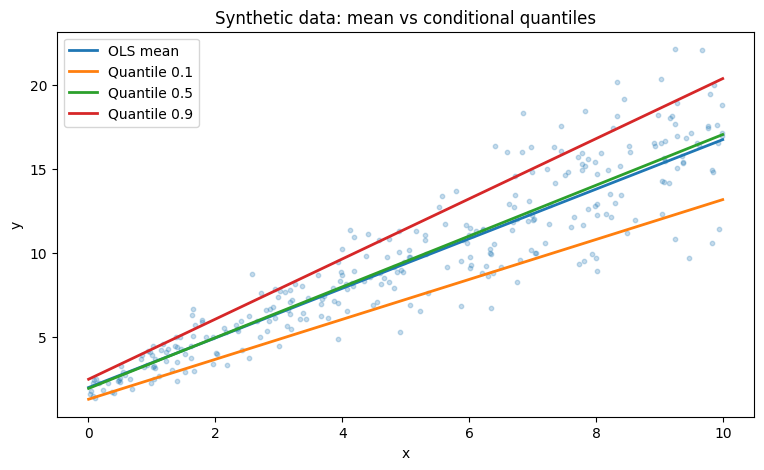

In [4]:
# Fit OLS and Quantile Regression on the synthetic dataset
# (This example is deliberately simple: one feature + intercept.)

X = df_syn[["x"]].to_numpy()
y = df_syn["y"].to_numpy()

# Train/test split (fixed seed)
if SKLEARN_OK:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
else:
    # simple manual split
    idx = np.arange(len(X))
    rng.shuffle(idx)
    cut = int(0.75 * len(X))
    tr, te = idx[:cut], idx[cut:]
    X_train, X_test = X[tr], X[te]
    y_train, y_test = y[tr], y[te]

# OLS baseline
if SKLEARN_OK:
    ols = LinearRegression().fit(X_train, y_train)
    yhat_ols = ols.predict(X_test)
    print("OLS MAE:", mean_absolute_error(y_test, yhat_ols))
    print("OLS RMSE:", rmse(y_test, yhat_ols))

# Quantile regression using statsmodels (if available)
taus = [0.1, 0.5, 0.9]
preds = {}

if STATSMODELS_OK:
    X_train_sm = sm.add_constant(X_train)
    X_test_sm = sm.add_constant(X_test)
    for tau in taus:
        qr = sm.QuantReg(y_train, X_train_sm).fit(q=tau)
        preds[tau] = qr.predict(X_test_sm)
        print(f"Quantile {tau}: pinball loss =", pinball_loss(y_test, preds[tau], tau))

# Visualization: scatter + fitted quantiles
# We'll predict on a grid for nicer curves.
x_grid = np.linspace(X.min(), X.max(), 250).reshape(-1, 1)

plt.figure(figsize=(9, 5))
plt.scatter(X_test[:, 0], y_test, s=10, alpha=0.25)
if SKLEARN_OK:
    plt.plot(x_grid[:, 0], ols.predict(x_grid), linewidth=2, label="OLS mean")

if STATSMODELS_OK:
    x_grid_sm = sm.add_constant(x_grid)
    for tau in taus:
        # refit on all training data for smoother curves
        qr_full = sm.QuantReg(y_train, sm.add_constant(X_train)).fit(q=tau)
        plt.plot(x_grid[:, 0], qr_full.predict(x_grid_sm), linewidth=2, label=f"Quantile {tau}")

plt.title("Synthetic data: mean vs conditional quantiles")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## ۵. از صدک به بازه روی داده‌های واقعی

حالا به داده‌های واقعی می‌رویم. در این درس (به‌صورت تصادفی از میان فایل‌های موجود)، چند دیتاست رگرسیونی را استفاده می‌کنیم:

1. **Diamonds** (`diamonds.csv`) — هدف پیوسته با الگوهای ناهمسان‌واریانس واضح.  
2. **House prices** (`house-prices.csv`) — دیتاست کوچک با ویژگی‌های عددی و رده‌ای.  
3. **Salaries** (`salaries.csv`) — دیتاست بسیار کوچک برای یک مینی‌پروژه آموزشی.

تمرکز ما:
- ساخت PI مبتنی بر صدک‌ها
- بررسی پوشش تجربی
- بحث درباره خطاها و دام‌های رایج در کاربردهای واقعی

---

### راهنمای عملی: انتخاب سطح بازه بر اساس نیاز تصمیم
یک سطح بازه برای همه کاربردها مناسب نیست:
- کنترل ریسک محافظه‌کارانه: بازه ۹۵٪ یا ۹۹٪
- برنامه‌ریزی عملیاتی: بازه ۸۰٪ تا ۹۰٪
- رتبه‌بندی/غربال‌گری: صدک یک‌طرفه (مثلاً صدک ۹۰٪ ریسک)

به زبان کسب‌وکار، صدک‌ها می‌توانند **سطح سرویس**، **ریسک‌پذیری** یا **تحمل SLA** را کُدگذاری کنند.


## ۶. دیتاست ۱: Diamonds — بازه‌های صدکی که با carat پهن‌تر می‌شوند

قیمت الماس معمولاً این ویژگی‌ها را دارد:
- میانگین شرطی با افزایش carat بالا می‌رود.
- پراکندگی نیز اغلب افزایش می‌یابد: برای الماس‌های بزرگ‌تر، قیمت به کیفیت و بازار وابستگی بیشتری دارد.
- باقیمانده‌ها در فضای قیمت خام می‌توانند نامتقارن باشند.

در این بخش:
1. دیتاست را با مسیر نسبیِ استاندارد مخزن بارگذاری می‌کنیم.
2. سه مدل صدکی ($\tau=0.05, 0.5, 0.95$) برازش می‌کنیم.
3. یک PI ۹۰٪ می‌سازیم و پوشش را ارزیابی می‌کنیم.

### نکات پیاده‌سازی
از `sklearn.linear_model.QuantileRegressor` استفاده می‌کنیم که یک مسئله pinball-loss با رگولاریزیشن را حل می‌کند.  
اگر محیط شما scikit-learn یا SciPy سازگار نداشته باشد، بخش‌های مفهومی را دنبال کنید؛ همچنین مثال `statsmodels` در بخش داده مصنوعی یک جایگزین ساده است.


In [5]:
# Dataset 1 (random pick): diamonds.csv (regression)
# Target: price; Features: carat and a few numeric predictors.
# Relative path convention:
path_diamonds = "../../../Datasets/Regression/diamonds.csv"
df_dia = read_csv_rel(path_diamonds)

# Basic cleaning: drop obvious NA rows (if any)
df_dia = df_dia.dropna().copy()

# Keep a manageable subset of columns for fast experimentation
cols = ["carat", "depth", "table", "x", "y", "z", "price"]
df_dia = df_dia[cols].copy()

df_dia.head()

,carat,depth,table,x,y,z,price
0,0.23,61.5,55.0,3.95,3.98,2.43,326
1,0.21,59.8,61.0,3.89,3.84,2.31,326
2,0.23,56.9,65.0,4.05,4.07,2.31,327
3,0.29,62.4,58.0,4.20,4.23,2.63,334
4,0.31,63.3,58.0,4.34,4.35,2.75,335


tau=0.05 pinball loss: 90.41008223897532
tau=0.50 pinball loss: 410.81473391794475
tau=0.95 pinball loss: 148.32638883187587
Empirical coverage [5%,95%]: 0.9012235817575084
Average interval width: 3527.5033096433276
Median-prediction MAE: 821.6294678358895


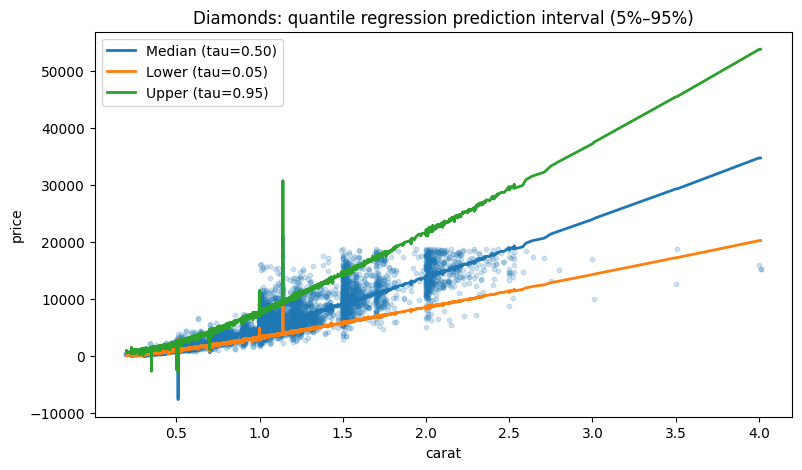

In [6]:
# Train/test split and fit quantile models for prediction intervals
X = df_dia.drop(columns=["price"])
y = df_dia["price"].to_numpy()

if not SKLEARN_OK:
    raise RuntimeError("This section requires scikit-learn (QuantileRegressor, train_test_split).")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

# Standardize numeric features (helps optimization stability)
numeric_features = list(X.columns)
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), numeric_features)
    ],
    remainder="drop",
)

def fit_quantile_pipeline(tau: float, alpha: float = 1e-4):
    # QuantileRegressor minimizes pinball loss + L2 regularization (alpha)
    return Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", QuantileRegressor(quantile=tau, alpha=alpha, solver="highs")),
    ])

taus = [0.05, 0.5, 0.95]
models = {}
preds = {}

for tau in taus:
    m = fit_quantile_pipeline(tau=tau, alpha=1e-4)
    m.fit(X_train, y_train)
    models[tau] = m
    preds[tau] = m.predict(X_test)
    print(f"tau={tau:0.2f} pinball loss:", pinball_loss(y_test, preds[tau], tau))

# Compute prediction interval and metrics
lower = preds[0.05]
median = preds[0.5]
upper = preds[0.95]

print("Empirical coverage [5%,95%]:", interval_coverage(y_test, lower, upper))
print("Average interval width:", interval_width(lower, upper))

# Compare to mean prediction error (median is often more robust than mean)
mae_median = mean_absolute_error(y_test, median)
print("Median-prediction MAE:", mae_median)

# Visualize: price vs carat with interval bands (holding other features at their observed values in test set)
# We plot against carat to interpret heteroscedasticity.
plt.figure(figsize=(9, 5))
order = np.argsort(X_test["carat"].to_numpy())
x_carat = X_test["carat"].to_numpy()[order]

plt.scatter(X_test["carat"].to_numpy(), y_test, s=10, alpha=0.2)
plt.plot(x_carat, median[order], linewidth=2, label="Median (tau=0.50)")
plt.plot(x_carat, lower[order], linewidth=2, label="Lower (tau=0.05)")
plt.plot(x_carat, upper[order], linewidth=2, label="Upper (tau=0.95)")
plt.title("Diamonds: quantile regression prediction interval (5%–95%)")
plt.xlabel("carat")
plt.ylabel("price")
plt.legend()
plt.show()

## ۷. تفسیر نتایج Diamonds

### ۷.۱ میانه در مقابل میانگین
پیش‌بینی میانه (صدک $\tau=0.5$) معمولاً مقاوم‌تر از میانگین است:
- نقاط پرت اثر بیشتری روی میانگین دارند.
- در توزیع‌های کج، میانگین به سمت دم بلند کشیده می‌شود.

### ۷.۲ پهنای بازه به‌عنوان تابعی از ویژگی‌ها
یکی از مهم‌ترین مزیت‌های PI مبتنی بر صدک این است که **پهنای بازه می‌تواند به $X$ وابسته باشد**.
- برای carat پایین، بازه ممکن است باریک‌تر باشد.
- برای carat بالا، بازه می‌تواند پهن‌تر شود.

اگر نویز به ویژگی‌ها وابسته باشد، بازه‌های با پهنای ثابت معمولاً کالیبره نیستند.

### ۷.۳ پوشش تضمین‌شده نیست
حتی اگر صدک ۵٪ و ۹۵٪ را برازش کنید، پوشش تجربی ممکن است دقیقاً ۹۰٪ نباشد. دلایل:
- محدودیت داده و خطای مدل
- بایاس ناشی از رگولاریزیشن (پارامتر alpha)
- تغییر توزیع بین train/test
- crossing یا مسائل عددی

در عمل، بازه‌ها را اغلب **کالیبره** می‌کنند؛ اینجا ایده‌های کانفورمال مطرح می‌شود.


## ۸. دیتاست ۲: House prices — داده‌های واقعی، پیش‌پردازش واقعی

داده‌های جدولی واقعی معمولاً شامل موارد زیر هستند:
- ویژگی‌های عددی
- ویژگی‌های رده‌ای (categorical)
- مقادیر گمشده و جزئیات داده‌ای

رگرسیون صدکی جایگزین «بهداشت داده» نمی‌شود:
- تقسیم درست train/test
- برازش پیش‌پردازش فقط روی train (pipeline discipline)
- جلوگیری از leakage
- ارزیابی روی داده نگه‌داشته‌شده

در ادامه:
- `ColumnTransformer` برای تفکیک ستون‌های عددی و رده‌ای
- `OneHotEncoder` برای ستون‌های رده‌ای
- `StandardScaler` برای پایداری عددی
- سه مدل برای $\tau=0.1, 0.5, 0.9$ جهت ساخت PI ۸۰٪

همچنین یک مدل میانگین را به‌عنوان baseline مقایسه می‌کنیم.


Mean baseline MAE: 8338.003966571283
Median (tau=0.5) MAE: 8066.5632304815335
Pinball loss tau=0.1: 1830.0234994825798
Pinball loss tau=0.5: 4033.2816152407668
Pinball loss tau=0.9: 1970.6123922835889
Empirical coverage [10%,90%]: 0.75
Average interval width: 27156.124185886336


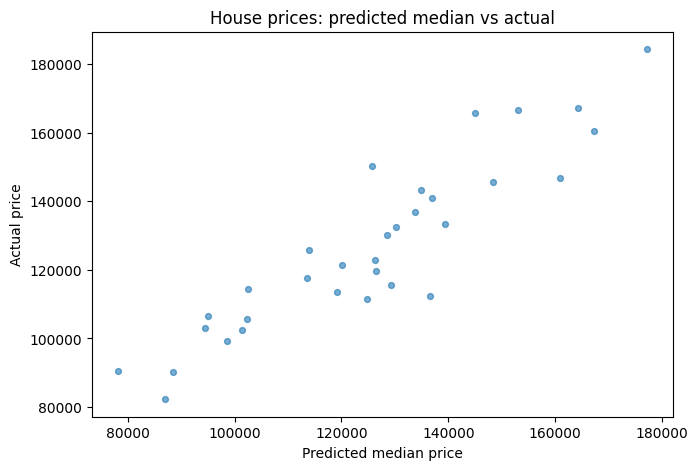

In [7]:
# Dataset 2 (random pick): house-prices.csv (regression)
path_hp = "../../../Datasets/Regression/house-prices.csv"
df_hp = read_csv_rel(path_hp).dropna().copy()

# Target and features
y = df_hp["Price"].to_numpy()
X = df_hp.drop(columns=["Price"])

# Identify numeric vs categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# Build preprocessing
# OneHotEncoder API differs across sklearn versions; handle both.
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num_cols),
        ("cat", Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", ohe)]), cat_cols),
    ],
    remainder="drop",
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

# Fit quantile models and a mean baseline
ols = Pipeline(steps=[("preprocess", preprocess), ("model", LinearRegression())])
ols.fit(X_train, y_train)
yhat_mean = ols.predict(X_test)

taus = [0.1, 0.5, 0.9]
q_models, q_preds = {}, {}
for tau in taus:
    qr = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", QuantileRegressor(quantile=tau, alpha=1e-3, solver="highs")),
    ])
    qr.fit(X_train, y_train)
    q_models[tau] = qr
    q_preds[tau] = qr.predict(X_test)

# Metrics
print("Mean baseline MAE:", mean_absolute_error(y_test, yhat_mean))
print("Median (tau=0.5) MAE:", mean_absolute_error(y_test, q_preds[0.5]))
for tau in taus:
    print(f"Pinball loss tau={tau}:", pinball_loss(y_test, q_preds[tau], tau))

# Interval metrics
lower, upper = q_preds[0.1], q_preds[0.9]
print("Empirical coverage [10%,90%]:", interval_coverage(y_test, lower, upper))
print("Average interval width:", interval_width(lower, upper))

# Simple visualization: predicted vs actual with interval width as a diagnostic
plt.figure(figsize=(7.5, 5))
plt.scatter(q_preds[0.5], y_test, s=18, alpha=0.6)
plt.title("House prices: predicted median vs actual")
plt.xlabel("Predicted median price")
plt.ylabel("Actual price")
plt.show()

## ۹. ارزیابی مدل‌های صدکی: فراتر از MAE/RMSE

رگرسیون صدکی مفاهیم ارزیابی جدیدی را وارد می‌کند.

### ۹.۱ زیان پین‌بال (معیار سازگار با صدک)
برای یک $\tau$ ثابت، کمینه‌سازی زیان پین‌بال تحت فرض‌های استاندارد، صدک شرطی درست را هدف می‌گیرد. به‌عنوان معیار ارزیابی نیز، با هدف مدل هم‌راستا است؛ مشابه این‌که log-loss برای طبقه‌بندی احتمالاتی مناسب است.

### ۹.۲ کالیبراسیون و تیزی (پهنای بازه)
برای بازه‌ها دو محور اصلی داریم:
- **کالیبراسیون** (پوشش نزدیک به مقدار اسمی)
- **تیزی/Sharpness** (بازه‌ها خیلی پهن نباشند)

این یک سازش بنیادی است: با پهن کردن بازه می‌توان پوشش را افزایش داد، اما کاربردپذیری کاهش می‌یابد.

### ۹.۳ امتیازدهی بازه (اختیاری)
در سناریوهای عملی، می‌توان معیارهایی مانند Winkler score را استفاده کرد که هم پهنا را جریمه می‌کند و هم خروج از بازه را.

در تولید (production) بهتر است گزارش کنید:
- پهنای بازه در پوشش هدف
- خطای پوشش نسبت به مقدار اسمی
- تحلیل جداگانه خطای دم‌ها (کم‌پوشش در پایین/بالا)


## ۱۰. crossing در صدک‌ها: یک دام عملی

وقتی صدک‌ها را جداگانه برازش می‌کنید (مثلاً 0.1، 0.5، 0.9)، ممکن است ترتیب منطقی نقض شود:
$$
\hat{Q}_{0.1}(x) > \hat{Q}_{0.5}(x) \quad \text{یا} \quad \hat{Q}_{0.5}(x) > \hat{Q}_{0.9}(x).
$$

این مشکل را **Quantile Crossing** می‌نامند و می‌تواند به دلایل زیر رخ دهد:
- خطای مدل یا ناکافی بودن مدل
- داده کم
- رگولاریزیشن
- تفاوت‌های عددی در حل مسئله

### راهکارهای رایج
1. **مرتب‌سازی پس از پیش‌بینی:** برای هر $x$، صدک‌های پیش‌بینی‌شده را sort کنید تا یکنوا شوند.  
   ساده است اما اگر crossing زیاد باشد، معنای صدک‌ها مخدوش می‌شود.
2. **برازش مشترک با قید یکنوایی:** پیچیده‌تر اما اصولی‌تر.
3. **مدل‌هایی با crossing کمتر:** مثل برخی روش‌های boosting با زیان صدکی.

در چارچوب مقدماتی، مرتب‌سازی پس از پیش‌بینی یک baseline مفید برای تشخیص است.


In [8]:
# Demonstration of a simple post-hoc "fix" for quantile crossing on the house-prices example.
# This is just a utility pattern; it does not correct deeper model issues.

if SKLEARN_OK:
    # We have q_preds from the house-prices section if that cell executed.
    if 'q_preds' in globals() and 0.1 in q_preds and 0.5 in q_preds and 0.9 in q_preds:
        Q = np.vstack([q_preds[0.1], q_preds[0.5], q_preds[0.9]]).T  # shape (n, 3)
        Q_sorted = np.sort(Q, axis=1)
        lower_fixed, median_fixed, upper_fixed = Q_sorted[:, 0], Q_sorted[:, 1], Q_sorted[:, 2]
        
        print("Coverage before fix:", interval_coverage(y_test, q_preds[0.1], q_preds[0.9]))
        print("Coverage after  fix:", interval_coverage(y_test, lower_fixed, upper_fixed))
        print("Avg width before:", interval_width(q_preds[0.1], q_preds[0.9]))
        print("Avg width after :", interval_width(lower_fixed, upper_fixed))
    else:
        print("House-prices quantile predictions not found; run the house-prices cell first.")


Coverage before fix: 0.75
Coverage after  fix: 0.75
Avg width before: 27156.124185886336
Avg width after : 27171.407059924473


## ۱۱. کالیبراسیون بازه‌ها: CQR (مقدمه)

حتی با رگرسیون صدکی، پوشش تجربی ممکن است با مقدار اسمی متفاوت باشد. یک راهکار عملی این است که بازه‌ها را با ایده‌های **کانفورمال پیش‌بینی** کالیبره کنیم.

### ایده کلی
1. یک مدل صدک پایین $\hat{Q}_{\tau_{low}}(x)$ و یک مدل صدک بالا $\hat{Q}_{\tau_{high}}(x)$ برازش کنید.
2. روی یک **مجموعه کالیبراسیون** جدا، اندازه خروج $y$ از بازه پیش‌بینی‌شده را اندازه‌گیری کنید.
3. یک صدک از این انحراف‌ها را به‌عنوان ضریب اصلاح انتخاب کنید.
4. بازه نقاط تست را به اندازه این ضریب گسترش دهید.

با فرض‌های معمول exchangeability (تقریباً i.i.d.)، پوشش این بازه‌ها به‌طور نظری قابل تضمین است.

### چرا مهم است؟
- نسبتاً مستقل از مدل است و برای مدل‌های مختلف قابل استفاده است.
- در بسیاری از مسائل، کالیبراسیون را با پیچیدگی کم بهتر می‌کند.
- با الگوی train/calibration/test در سیستم‌های ML سازگار است.

در سلول بعد یک پیاده‌سازی حداقلی روی دیتاست diamonds نشان داده می‌شود.


In [ ]:
# Optional: Conformalized Quantile Regression (CQR) for calibrated prediction intervals
# This is a practical trick: fit lower/upper quantiles, then use a calibration set to adjust them
# so that empirical coverage is closer to the target, with minimal assumptions.

if not SKLEARN_OK:
    raise RuntimeError("This section requires scikit-learn.")

# We'll reuse diamonds features, but create train/calibration/test splits
X = df_dia.drop(columns=["price"])
y = df_dia["price"].to_numpy()

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_cal, y_train, y_cal = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=RANDOM_STATE)  # 0.25 of 0.8 = 0.2

# Rebuild a numeric-only preprocess for diamonds
numeric_features = list(X.columns)
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), numeric_features)
    ],
    remainder="drop",
)

alpha_target = 0.10  # target miscoverage => 90% prediction interval
tau_low = alpha_target / 2
tau_high = 1 - alpha_target / 2

low_model = Pipeline(steps=[("preprocess", preprocess), ("model", QuantileRegressor(quantile=tau_low, alpha=1e-4, solver="highs"))])
high_model = Pipeline(steps=[("preprocess", preprocess), ("model", QuantileRegressor(quantile=tau_high, alpha=1e-4, solver="highs"))])

low_model.fit(X_train, y_train)
high_model.fit(X_train, y_train)

# Predict on calibration set
q_low_cal = low_model.predict(X_cal)
q_high_cal = high_model.predict(X_cal)

# CQR conformity scores (how far y lies outside the predicted band)
s = np.maximum(q_low_cal - y_cal, y_cal - q_high_cal)

# Choose the (1 - alpha) quantile of scores (with a finite-sample correction)
# In conformal prediction, use the ceil((n+1)*(1-alpha)) order statistic.
n_cal = len(s)
k = int(np.ceil((n_cal + 1) * (1 - alpha_target))) - 1
s_sorted = np.sort(s)
q_hat = s_sorted[np.clip(k, 0, n_cal - 1)]

print("Calibration adjustment q_hat:", q_hat)

# Apply on test set
q_low_test = low_model.predict(X_test) - q_hat
q_high_test = high_model.predict(X_test) + q_hat

print("CQR empirical coverage (target 90%):", interval_coverage(y_test, q_low_test, q_high_test))
print("CQR average width:", interval_width(q_low_test, q_high_test))

# Compare to uncalibrated interval
q_low_unc = low_model.predict(X_test)
q_high_unc = high_model.predict(X_test)
print("Uncalibrated coverage:", interval_coverage(y_test, q_low_unc, q_high_unc))
print("Uncalibrated avg width:", interval_width(q_low_unc, q_high_unc))

## ۱۲. مینی‌پروژه: ساخت «باند حقوق» (صرفاً برای تمرین)

در بسیاری از کاربردها، PI به شکل «باند» گزارش می‌شود:
- مقدار معمول (میانه)
- کران پایین (محافظه‌کارانه)
- کران بالا (خوش‌بینانه)

دیتاست salaries کوچک و عمدتاً رده‌ای است؛ بنابراین این بخش بیشتر برای تمرین مکانیک پیاده‌سازی است تا نتیجه‌گیری آماری. در تولید واقعی نیاز دارید:
- داده بیشتر
- ویژگی‌های بهتر
- بررسی‌های حاکمیتی (fairness، leakage، سیاست‌ها)

با این حال، این تمرین به شما کمک می‌کند:
- پیش‌پردازش ویژگی‌های رده‌ای را تمرین کنید
- چند مدل صدکی برازش کنید
- برای هر رکورد یک باند صدکی گزارش کنید


In [ ]:
# Dataset 3 (random pick): salaries.csv (regression, small)
path_sal = "../../../Datasets/Regression/salaries.csv"
df_sal = read_csv_rel(path_sal).dropna().copy()
df_sal.head()

In [ ]:
# Mini-project: build a simple quantile-based salary band for a numeric proxy feature
# This dataset is small and mostly categorical; we'll create a simple "experience proxy"
# using Age and a rough job grouping. This is purely illustrative.

if not SKLEARN_OK:
    raise RuntimeError("This section requires scikit-learn.")

df = df_sal.copy()

# Create features
df["JobGroup"] = df["Job"].str.lower().str.replace(" ", "_")
X = df[["Age", "JobGroup"]]
y = df["Salary"].to_numpy()

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), ["Age"]),
        ("cat", Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", ohe)]), ["JobGroup"]),
    ]
)

# With tiny data, we avoid a test split; focus on mechanics.
taus = [0.1, 0.5, 0.9]
preds = {}
for tau in taus:
    model = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", QuantileRegressor(quantile=tau, alpha=1e-2, solver="highs")),
    ])
    model.fit(X, y)
    preds[tau] = model.predict(X)

df_out = df.copy()
df_out["pred_q10"] = preds[0.1]
df_out["pred_q50"] = preds[0.5]
df_out["pred_q90"] = preds[0.9]
df_out[["Name", "Age", "Job", "Salary", "pred_q10", "pred_q50", "pred_q90"]].head(10)

## ۱۳. چک‌لیست عملی برای رگرسیون صدکی در داده‌های جدولی

### داده و تقسیم‌بندی
- تقسیم درست train/validation/test؛ در صورت نیاز تقسیم زمانی/گروهی.
- پیش‌پردازش فقط روی train برازش شود (pipeline).
- مراقب leakage باشید؛ ویژگی‌های پس از رخداد می‌توانند اعتبار بازه را از بین ببرند.

### انتخاب مدل
- رگرسیون خطیِ صدکی یک baseline قدرتمند و قابل‌تفسیر است.
- برای روابط غیرخطی، می‌توان سراغ مدل‌های درختی/boosting با زیان صدکی رفت (فراتر از این درس).
- رگولاریزیشن مهم است: مقدار زیاد می‌تواند صدک‌ها را بایاس کند و پوشش را خراب کند.

### ارزیابی
- زیان پین‌بال را برای هر $\tau$ گزارش کنید.
- برای بازه‌ها، پوشش و پهنا را گزارش کنید.
- پوشش را بر اساس زیرگروه‌ها بررسی کنید (مثلاً بازه‌های carat یا محله‌ها).

### قابلیت اعتماد
- اگر پوشش مناسب نیست، کالیبراسیون (مثل CQR) را امتحان کنید.
- در صورت احتمال distribution shift، drift پوشش را در تولید پایش کنید.

### ارتباط‌سازی
- بازه‌ها «قطعیت» نیستند. همیشه سطح اسمی و نتیجه اعتبارسنجی را ذکر کنید.
- در کاربردهای حساس، با قیود دامنه و بازبینی انسانی ترکیب کنید.


## ۱۴. تمرین‌ها (مفهومی + کدنویسی)

### سوال‌های مفهومی
1. تفاوت CI و PI را در یک پاراگراف توضیح دهید.
2. چرا OLS میانگین شرطی را برآورد می‌کند اما رگرسیون صدکی با $\tau=0.5$ میانه شرطی را؟
3. در زیان پین‌بال، چرا برای صدک‌های بالا کم‌پیش‌بینی جریمه بیشتری دارد؟
4. یک سناریوی کسب‌وکاری مثال بزنید که صدک ۹۰٪ از میانگین مفیدتر باشد.
5. Quantile crossing چیست و چرا برای PI مشکل‌ساز است؟
6. چرا پوشش تجربی ممکن است با مقدار اسمی اختلاف داشته باشد حتی اگر صدک‌های ۵٪ و ۹۵٪ را برازش کنید؟
7. برای تضمین پوشش کانفورمال، چه فرض‌هایی لازم است؟

### تمرین‌های کدنویسی
1. **گسترش داده مصنوعی:** نویز را نامتقارن کنید (مثلاً مؤلفه نمایی اضافه کنید). منحنی‌های صدکی چگونه تغییر می‌کنند؟
2. **پوشش زیرگروهی در diamonds:** پوشش را در بازه‌های carat جداگانه محاسبه کنید. آیا همه جا کالیبره است؟
3. **جستجوی alpha در house-prices:** با تغییر `alpha` ببینید پوشش و پهنا چگونه تغییر می‌کند.
4. **بازه یک‌طرفه:** فقط کران پایین بسازید (مثلاً $\tau=0.1$) و معیار ارزیابی مناسب آن را تعریف کنید.
5. **امتیاز بازه:** یک معیار ساده که هم پهنا و هم خروج از بازه را جریمه کند پیاده‌سازی کنید و دو روش (خام و CQR) را مقایسه کنید.

### مینی‌کاپستون
یک دیتاست رگرسیون دیگر از مخزن انتخاب کنید (مثل `European_Ski_Resorts.csv` یا `earthquake.csv`) و:
1. هدف و ویژگی‌ها را تعریف کنید.
2. حداقل سه صدک برازش کنید.
3. پوشش و پهنا را گزارش کنید.
4. ۸ تا ۱۰ خط تفسیر درباره نتایج و نقاط شکست بنویسید.

---

### قالب پیشنهادی گزارش
در گزارش مدل صدکی/بازه‌ای، این موارد را بنویسید:
- دیتاست و راهبرد split
- کلاس مدل و هایپرپارامترها
- صدک‌ها ($\tau$ها)
- زیان پین‌بال برای هر صدک
- پوشش و پهنا
- بررسی زیرگروهی (در صورت نیاز)


## ۱۵. جمع‌بندی

در این درس یاد گرفتید چگونه از پیش‌بینی نقطه‌ای به خروجی‌های همراه با عدم‌قطعیت حرکت کنید و **صدک‌های شرطی** را مدل‌سازی کنید.

نکات کلیدی:
- رگرسیون صدکی $Q_\tau(Y\mid X)$ را با کمینه‌سازی زیان پین‌بال برآورد می‌کند.
- جفتِ صدک‌ها، **بازه‌های پیش‌بینی** می‌سازند که با ناهمسان‌واریانس و نامتقارنی سازگار می‌شوند.
- پوشش و پهنا محورهای اصلی ارزیابی بازه‌ها هستند.
- crossing و عدم‌کالیبراسیون در عمل رایج‌اند.
- CQR می‌تواند پوشش را با یک الگوی ساده train/calibration/test بهبود دهد.

این موضوع مستقیماً به درس‌های بعدی درباره عدم‌قطعیت، قابلیت اعتماد و کانفورمال پیش‌بینی مرتبط است.


### منابع (در سطح کلی)
- Koenker & Bassett (1978): مقاله بنیادی رگرسیون صدکی (ارجاع مفهومی).
- ادبیات کانفورمال پیش‌بینی (split conformal و conformalized quantile regression) برای ایده‌های کالیبراسیون بازه.
- مستندات scikit-learn و statsmodels برای پیاده‌سازی‌های عملی.

(در مخزن شما می‌توان منابع را به‌صورت لینک در README یا صفحه References اضافه کرد؛ این نوت‌بوک این بخش را عام و کوتاه نگه می‌دارد.)
